In [18]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

In [27]:
def get_data_fromString(filename, regular_mask, data_name=None):
    match = re.search(regular_mask, filename)

    if match:
        data = float(match.group(1))
        print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
    else:
        print(f"Data{('(' + data_name + ')') if data_name is not None else ''} is not found")
        try:
            data = float(input(f"Input data{('(' + data_name + ')') if data_name is not None else ''}: "))
            print(f"Current data{('(' + data_name + ')') if data_name is not None else ''}:", data)
        except Exception as e:
            print(e)
            data = 0.1
            print(f"Data set as {data}")
    print()
    return data

def get_data_fromNPZ(filename):
    data = np.load(f'data/{filename}')

    triangularity = get_data_fromString(filename, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "triangularity")
    elongation = get_data_fromString(filename, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "elongation")
    I = get_data_fromString(filename, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(filename, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    N, M = data["growth"].shape

    data_arr = []
    for i in range(N):
        for j in range(M):
            data_arr.append([data["delta_arr"][i], data["p_multy_arr"][j], data["growth"][i, j]])
    
    return triangularity, elongation, I, B, N, M, pd.DataFrame(data_arr, columns=['A', 'P', 'growth']), data["unstable_mode"]

def get_data_fromDAT(index=""):
    index_A = pd.read_table(f"data/A{index}.dat", sep=' ', header=None).to_numpy()[:, 0]
    header_P = pd.read_table(f"data/P{index}.dat", sep=' ', header=None).to_numpy()[0]
    
    growth = pd.read_table(f"data/growth{index}.dat", sep=' ', header=None)
    mode = pd.read_table(f"data/unstable_mode{index}.dat", sep=' ', header=None)

    triangularity = get_data_fromString(filename, r"triangularity=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "triangularity")
    elongation = get_data_fromString(filename, r"elongation=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "elongation")
    I = get_data_fromString(filename, r"I=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "I")
    B = get_data_fromString(filename, r"B=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)[^0-9]", "B")

    N, M = df.shape
    
    data_arr = []
    for i in range(N):
        for j in range(M):
            data_arr.append([index_A[i], header_P[j], growth.iloc[i, j]])
    
    return triangularity, elongation, I, B, N, M, pd.DataFrame(data_arr, columns=['A', 'P', 'growth']), mode.to_numpy()

def get_isoline(np_growth, df_data, growth_edge):
    zero_mask = abs(np_growth - growth_edge) < np_growth.std() / 4
    plot_data = df_data[zero_mask, :]
    
    plot_x = [plot_data[0, 0]]
    plot_y = [plot_data[0, 1]]
    plot_z = [plot_data[0, 2]]
    n_of_same_x = 1
    for x, y, z in plot_data[1:, :3]:
        if x == plot_x[-1]:
            plot_y[-1] += y
            plot_z[-1] += z
            n_of_same_x += 1
        else:
            plot_y[-1] /= n_of_same_x
            plot_z[-1] /= n_of_same_x
    
            plot_x.append(x)
            plot_y.append(y)
            plot_z.append(z)
            n_of_same_x = 1
    
    plot_y[-1] /= n_of_same_x
    plot_z[-1] /= n_of_same_x

    return plot_x, plot_y, plot_z

In [28]:
filename = "output-data_triangularity=1.8e-1.npz"

sigma, kappa, I, B, N, M, df, mode_data = get_data_fromNPZ(filename)
print(sigma, kappa, I, B, N, M)

Current data(triangularity): 0.18

Data(elongation) is not found


Input data(elongation):  1.95


Current data(elongation): 1.95

Data(I) is not found


Input data(I):  300


Current data(I): 300.0

Data(B) is not found


Input data(B):  0.7


Current data(B): 0.7

0.18 1.95 300.0 0.7 20 20


In [29]:
growth_edge = 0.1

plot_x, plot_y, plot_z = get_isoline(df.growth.to_numpy(), df.to_numpy(), growth_edge)

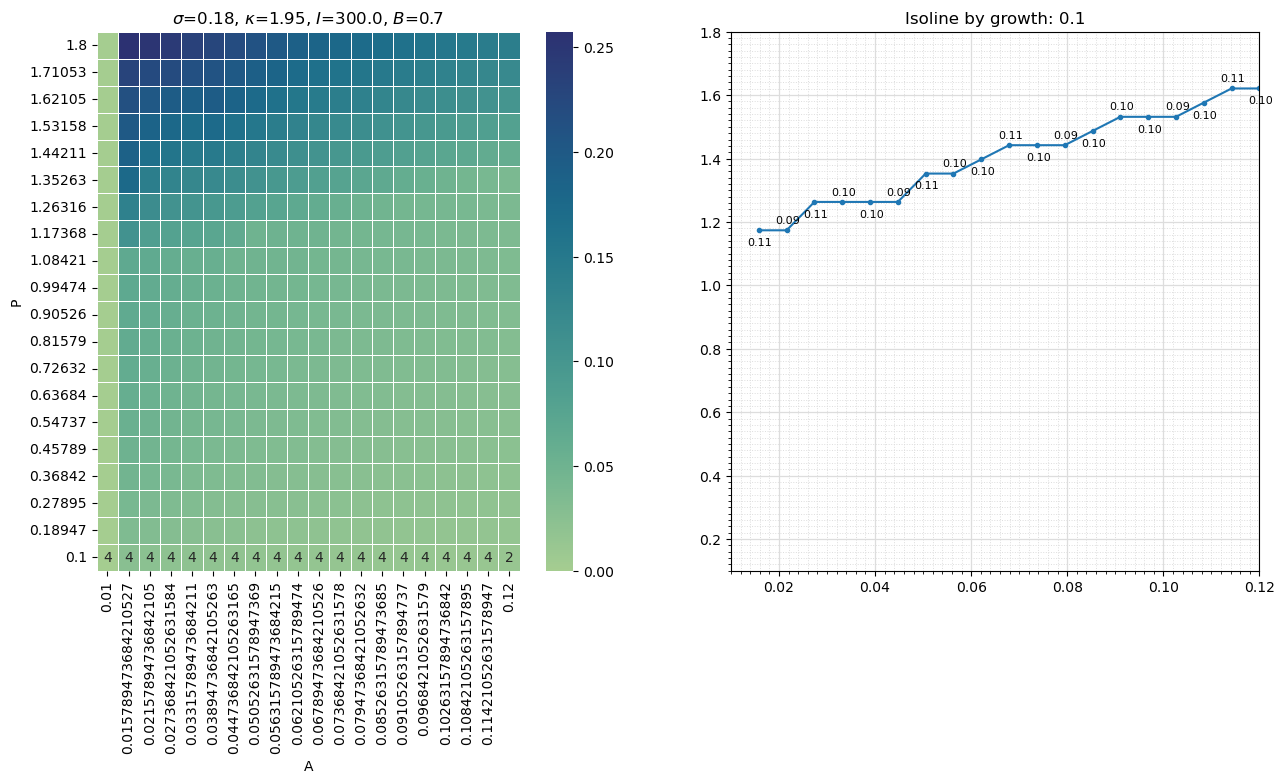

In [31]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_figwidth(15)
fig.set_figheight(7)

table = df.pivot(index='P', columns='A', values='growth')
annot_arr = mode_data[1:, 1:]

sns.heatmap(table, cmap="crest", annot=annot_arr.T, linewidth=.5, ax=ax1)
ax1.invert_yaxis()

# ax2.plot(plot_data[:, 0], plot_data[:, 1], marker="+", label='Direct', alpha=0.8)
# for i, (xi, yi) in enumerate(zip(plot_data[:, 0], plot_data[:, 1])):
#     ax2.annotate(f"{plot_data[i, 2]:.2f}",
#                  (xi, yi), textcoords="offset points",
#                  fontsize=8, xytext=(-8, 5))

ax2.plot(plot_x, plot_y, marker=".")  # , label='Average', alpha=0.8, linewidth=.5
for i, (xi, yi) in enumerate(zip(plot_x, plot_y)):
    ax2.annotate(f"{plot_z[i]:.2f}",
                 (xi, yi), textcoords="offset points",
                 fontsize=8, xytext=(-8, (5 if i%2 else -11)))

# ax2.legend()
ax2.set_xlim([df.A.min(), df.A.max()])
ax2.set_ylim([df.P.min(), df.P.max()])

ax2.grid(which='major', color='#DDDDDD', linewidth=0.9)
ax2.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_minor_locator(AutoMinorLocator(10))

ax1.set_title(f"$\\sigma$={sigma}, $\\kappa$={kappa}, $I$={I}, $B$={B}")
ax2.set_title(f"Isoline by growth: {growth_edge}")

plt.show()